In [1]:
from os import listdir
from os.path import isfile, join
import dicom
import pylab

In [2]:
# defines a utilit function to display array as image
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [3]:
patientname = "0d941a3ad6c889ac451caf89c46cb92a"

In [4]:
dicompath = "../dicom/" + patientname
dicomfiles = [f for f in listdir(dicompath) if isfile(join(dicompath, f)) and f.endswith(".dcm")]

In [5]:
print(len(dicomfiles))

177


In [6]:
ds = dicom.read_file(dicompath+"/"+dicomfiles[0])

In [7]:
assert(ds.PatientName == patientname)

In [8]:
# Order the slices (one slide per dicom file) by SliceLocation
def compareBy1(x, y):
    delta = x[1] - y[1]
    if delta == 0:
        return 0
    if delta < 0:
        return -1
    else:
        return 1
L = [(dcmf, float(dicom.read_file(dicompath+"/"+dcmf).SliceLocation)) for dcmf in dicomfiles]
orderedL = sorted(L, cmp=compareBy1)
orderedL[0:10]

[('1f8d574cf09da3158b9102a87c799075.dcm', -327.5),
 ('5d43a2e79841abed4f05fba7490c4715.dcm', -325.5),
 ('93ab2bab6b01f5dd63affddaf49642cc.dcm', -323.5),
 ('e3137049eac3fa1d79d5d2b4c04bb7c3.dcm', -321.5),
 ('241f8753c982bffe232fde5e2c718090.dcm', -319.5),
 ('d2e23697516fa3c44aaeb15ff3d63ce1.dcm', -317.5),
 ('c72d9a65cb0a40f5725e37c1282abde3.dcm', -315.5),
 ('2c0d0e22fccc44167740a0ecf6f0e261.dcm', -313.5),
 ('51bfb5fbb355f59cae532cc5b97b75ea.dcm', -311.5),
 ('2505e3ec7e16d127a534de352685cef0.dcm', -309.5)]

In [9]:
DSs = [dicom.read_file(dicompath+"/"+f_sl[0]) for f_sl in orderedL]

In [10]:
DSs[10].pixel_array.shape

(512, 512)

In [11]:
DSs[10].pixel_array.min(), DSs[10].pixel_array.max() # check grey scale

(-2000, 2475)

In [12]:
#pylab.imshow(ds.pixel_array, cmap=pylab.cm.bone)

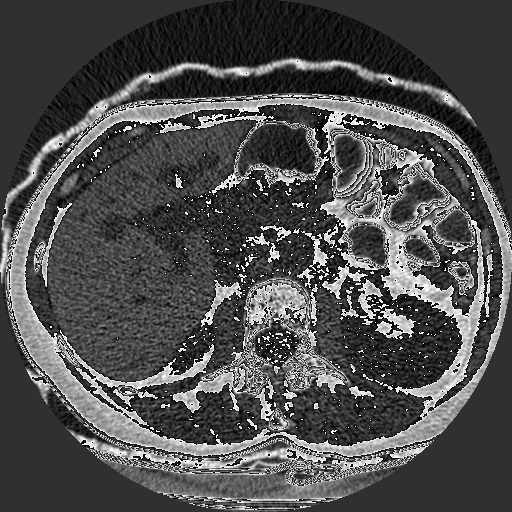

In [13]:
showarray(DSs[10].pixel_array)

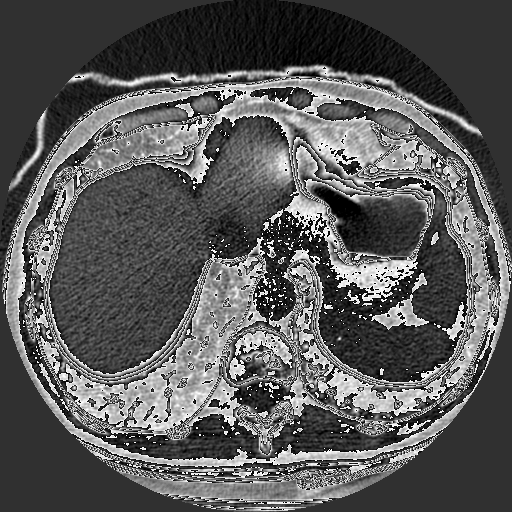

In [14]:
showarray(DSs[45].pixel_array)

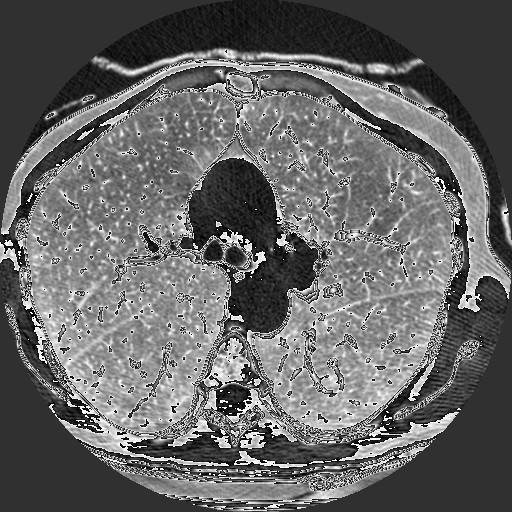

In [15]:
showarray(DSs[110].pixel_array)